In [1]:
import optris_csv as ocsv
from matplotlib.pyplot import cm
import temperaturemap as tmap
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks, correlate, medfilt, convolve2d
from scipy.optimize import curve_fit
%matplotlib widget
import pandas as pd
from get_envelope import hl_envelopes_idx
import filters
print(f"Using temperature calibration version {tmap.VERSION}.")
import os
from scipy.special import erf

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_theme()

print(os.getcwd())


Using temperature calibration version 3.1.
C:\Users\allen\Code (Local)\EDET80k_Damage\Lasing Analysis\apps\temperature location dependence


In [2]:
data = ocsv.OptrisDataset("./r1data.dat").build_array_data()
TIME_CUTOFF = 9900
data = data[data["time"] <= TIME_CUTOFF]
OPTRIS_SIGMA = 2 

# print(data.keys())

In [3]:
print(np.max(np.diff(data["time"])))
print(np.min(np.diff(data["time"])))

0.01300000000082946
0.011999999998806743


Initialize relevant data arrays

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


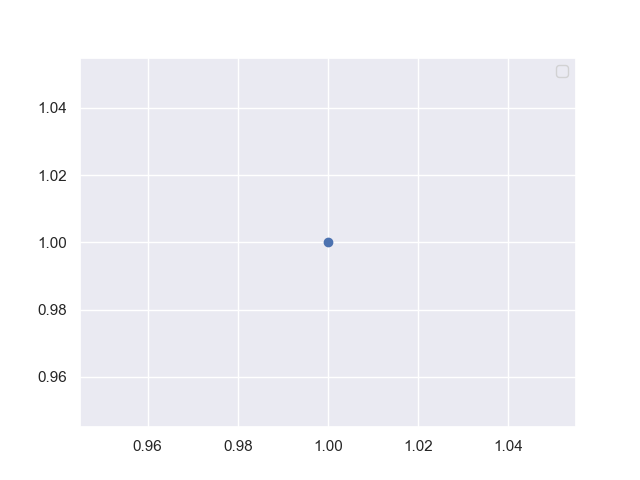

In [4]:
time = data["time"]

brick_temperature = data["tape brick"]

Al_map = tmap.maps["Al"].true_temperature
Al_sigma_map = tmap.maps["Al"].propagate_error
edgemap = tmap.maps["Si_Bright"].true_temperature

raw_edgetemp_unfiltered = data["Chip Periphery Left"]

raw_topedge_unfiltered = data["Chip Periphery Top"]

raw_edgetemp = savgol_filter(raw_edgetemp_unfiltered, 72, 4)
raw_topedgetemp = savgol_filter(raw_topedge_unfiltered, 72, 4)
topedgetemp = edgemap(raw_topedge_unfiltered)
edgetemp = edgemap(raw_edgetemp)

ROI_rawdata_unfiltered = data["ROI"]
ROI_rawdata = savgol_filter(ROI_rawdata_unfiltered, 72, 4)
ROI_maxtemp = Al_map(ROI_rawdata)#  - 15 - 3.2
ROI_maxtemp_sigma = Al_sigma_map(ROI_rawdata, OPTRIS_SIGMA * np.ones(len(ROI_maxtemp)))

chunk_size = 125

# envelope detection, not used for now but maybe useful for future automatic data acquisition
# chip_low_idx, chip_high_idx = hl_envelopes_idx(ROI_maxtemp, dmin=chunk_size, dmax=chunk_size)
# edge_low_idx, edge_high_idx = hl_envelopes_idx(edgetemp, dmin=chunk_size, dmax=chunk_size)

# print(len(high_idx))

plt.close("eggs")
fig1, ax1 = plt.subplots(num="eggs")
# ax1.plot(time, ROI_maxtemp, label="ROI Hotspot temperature")
# ax1.plot(time, edgetemp, label="Edge Temperature")
# ax1.plot(time, brick_temperature, label="Brick temperature")
# ax1.plot(time[chip_high_idx], ROI_maxtemp[chip_high_idx], label="chip envelope upper", lw=2)
# ax1.plot(time[edge_high_idx], edgetemp[edge_high_idx], label="edge envelope upper", lw=2)
# ax1.plot(time[chip_low_idx], ROI_maxtemp[chip_low_idx], label="chip envelope lower", lw=2)
# ax1.plot(time[edge_low_idx], edgetemp[edge_low_idx], label="edge envelope lower", lw=2)
# ax1.plot(time, edgetemp - np.interp(time, time[edge_low_idx], edgetemp[edge_low_idx]), label="flattened edge?", lw=2)
# ax1.plot(time, ROI_maxtemp - np.interp(time, time[chip_low_idx], ROI_maxtemp[chip_low_idx]), label="flattened ROI?", lw=2)

# ax1.plot(time, topedgetemp, label="Edge Temperature")

ax1.scatter(1, 1)
ax1.legend()

plt.show()

Acquire background temperature by means of a median filter with a window much larger than individual pulses. Subtract this background from temperature-time to get the approximate relative temperature differences per shot. Multiply the two to hopefully get a strong signal of when pulses occur

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


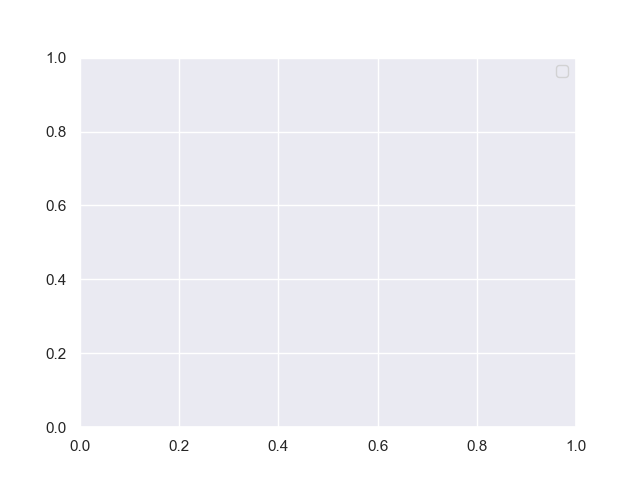

In [5]:
# filtered = filters.butter_lowpass_filter(ROI_rawdata, cutoff=0.4, fs=fs, order=1)

plt.close("bacon")
fig4, ax4 = plt.subplots(num="bacon")


# ROI
ROI_rawbg = medfilt(ROI_rawdata, kernel_size=301)
ROI_rawdelta = ROI_rawdata - ROI_rawbg

ROI_background = Al_map(ROI_rawbg)
ROI_delta = ROI_maxtemp - ROI_background
real_ROI_delta = ROI_maxtemp - medfilt(ROI_rawdata, kernel_size=801)

# edges - left first
edge_background = edgemap(medfilt(raw_edgetemp, kernel_size=301))
edge_delta = edgetemp - edge_background
edge_background = edgemap(medfilt(raw_edgetemp, kernel_size=801))
real_edge_delta = edgetemp - edge_background

top_edge_background = edgemap(medfilt(raw_topedgetemp, kernel_size=301))
top_edge_delta = topedgetemp - top_edge_background
top_edge_background = edgemap(medfilt(raw_topedgetemp, kernel_size=801))
real_top_edge_delta = topedgetemp - top_edge_background

# subtract edge background from ROI for more accurate  ax temps?
ROI_aggdelta = ROI_maxtemp - edge_background


edge_delta_no_negatives = edge_delta
edge_delta_no_negatives[np.logical_and(edge_delta < 0, ROI_delta < 0)] = 0

# ax4.plot(time, ROI_background, label="ROI median filtered")
# ax4.plot(time, ROI_maxtemp, label="ROI base signal", alpha=0.5)
# ax4.plot(time, ROI_delta, label="ROI subtracted", alpha=0.5)

# ax4.plot(time, edge_background, label="edge median filtered")
# ax4.plot(time, edgetemp, label="edge base signal", alpha=0.5)
# ax4.plot(time, edge_delta, label="edge subtracted", alpha=0.5)

# ax4.plot(time, ROI_aggdelta, label="more realistic ROI peaks", alpha=0.5)

# ax4.plot(time, edge_delta, label="", alpha=0.5)

# cross_correlated_signals = correlate(edge_delta, ROI_delta, mode="same")

prod = ROI_delta * edge_delta_no_negatives ** 2
prod[prod < 0] = 0
product = np.sqrt(prod)
# ax4.plot(time, cross_correlated_signals, label="cross-correlated deltas", alpha=0.5)
added = product + edge_delta
# ax4.plot(time, added, label="peak detection signal", alpha=0.5)



ax4.legend(loc="upper right")
plt.show()

In [6]:
def pad_indices(indices, window):
    padleft, padright = window
    total_width = padleft + padright + 1
    output = np.zeros((*np.shape(indices), total_width), dtype=int)
    output[...,padleft] = indices
    for col in range(padleft):
        output[..., col] = output[...,padleft] - (padleft - col) * np.ones(len(indices))
    for col in range(padleft + 1, total_width):
        output[..., col] = output[...,padleft] + (padright + col - total_width + 1) * np.ones(len(indices))

    output[output <= 0] = 0
    
    return output

# beagle = np.arange(1, 10).reshape((3, 3))
# print(beagle)
# print(pad_indices(beagle, (1, 2)))

def get_highest_window_value(data, indices, window):
    return np.max(data[pad_indices(indices, window)], axis=-1)


In [7]:
row_intervals = [
    (0, 258),
    (258, 539.4),
    (540, 791),
    (792, 1080),
    (1081, 1345),
    (1346, 1655),
    (1656, 1956),
    (1957, 2114),
    (2114, 2239),
    (2240, 2360), # 
    (2358, 2652),
    (2653, 2966),
    (2967, 3062.5),
    (3062, 3300),
    (3301, 3609),
    (3610, 3893),
    (3611, 3892),
    (3893, 4221),
    (4212, 4528), # 
    (4529, 4833),
    (4836, 5118),
    (5119, 5431),
    (5434, 5737),
    (5738, 6049),
    (6049, 6367),
    (6366, 6657.6),
    (6657.6, 6965.1),
    (6967, 7213),
    (7215.8, 7519.4),
    (7519.7, 7819.9),
    (7820.5, 8121.7),
    (8121.1, 8368.7),
    (8369, 8645)
    #,(8645, 8930)
]

peakfinding_settings = {
    12: (dict(height=0.2, distance=70, prominence=0.5), [], [0], [0]),
    7: (dict(height=1.1, distance=70, prominence=0.5), [], [], []),
    8: (dict(height=0.11, distance=70, prominence=0.5), [8, 21], [], []),
    9: (dict(height=0.35, distance=70, prominence=0.110), [], [], []),
    10: (dict(height=0.97, distance=100, prominence=0.110), [3], [], []),
    11: (dict(height=1.15, distance=100, prominence=0.110), [], [], []),
    13: (dict(height=0.732, distance=100, prominence=0.110), [], [], []),
    14: (dict(height=1.1, distance=100, prominence=0.110), [], [], []),
    15: (dict(height=1.2, distance=100, prominence=0.110), [], [], []),
    16: (dict(height=0.3, distance=200, prominence=0.5), [17], [], []),
    18: (dict(height=0.7, distance=200, prominence=0.5), [], [], []),
    19: (dict(height=0.7, distance=200, prominence=0.5), [], [], []),
    20: (dict(height=0.8, distance=200, prominence=0.5), [], [], []),
    21: (dict(height=0.72, distance=355, prominence=0.5), [5], [], []),
    22: (dict(height=0.72, distance=140, prominence=0.5), [8], [], []),
    23: (dict(height=0.72, distance=140, prominence=0.5), [14], [], []),
    24: (dict(height=0.425, distance=140, prominence=0.5), [3, 11, 15, 19], [], []),
    25: (dict(height=0.460, distance=140, prominence=0.5), [8, 13, 16, 22, 30], [], []),
    26: (dict(height=1.03, distance=140, prominence=0.5), [], [], []),
    27: (dict(height=0.69, distance=140, prominence=0.5), [], [], []),
    28: (dict(height=0.290, distance=140, prominence=0.1), [3, 9, 15, 20, 22, 26, 28], [], []),
    29: (dict(height=0.242, distance=400, prominence=0.1), [], [], []),
    30: (dict(height=0.242, distance=400, prominence=0.1), [], [], []),
    31: (dict(height=0.242, distance=170, prominence=0.1), [6, 11, 14, 16, 22, 40, 38, 18, 20], [], []),
    32: (dict(height=0.205, distance=300, prominence=0.1), [10, 19], [], []),
}
print(len(row_intervals))

33


0: t=0: 33 peaks
1: t=258: 33 peaks
2: t=540: 33 peaks
3: t=792: 33 peaks
4: t=1081: 33 peaks
5: t=1346: 33 peaks
6: t=1656: 33 peaks
7: t=1957: 33 peaks
8: t=2114: 33 peaks
9: t=2240: 32 peaks
10: t=2358: 33 peaks
11: t=2653: 33 peaks
12: t=2967: 33 peaks
13: t=3062: 33 peaks
14: t=3301: 33 peaks
15: t=3610: 33 peaks
16: t=3611: 33 peaks
17: t=3893: 33 peaks
18: t=4212: 33 peaks
19: t=4529: 33 peaks
20: t=4836: 33 peaks
21: t=5119: 33 peaks
22: t=5434: 33 peaks
23: t=5738: 33 peaks
24: t=6049: 33 peaks
25: t=6366: 33 peaks
26: t=6657.6: 33 peaks
27: t=6967: 33 peaks
28: t=7215.8: 33 peaks
29: t=7519.7: 33 peaks
30: t=7820.5: 33 peaks
31: t=8121.1: 33 peaks


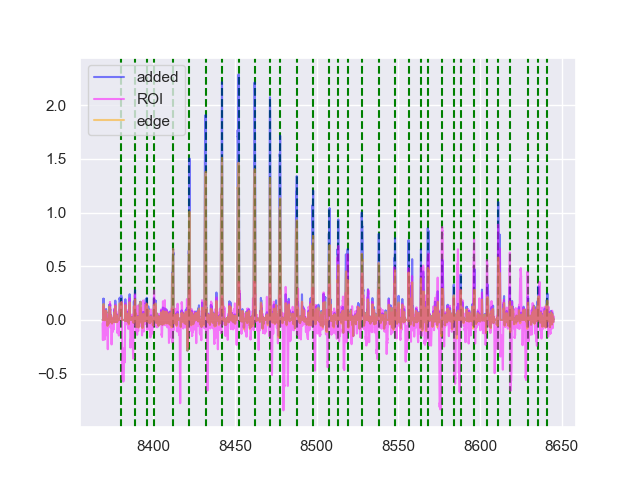

[  919  1595  2170  2522  3460  4264  5052  5856  6670  7454  8210  8710
  9523 10328 11128 11560 12019 12708 13545 14342 15005 15614 15949 16658
 17223 17560 18233 18855 19404 19970 20864 21373 21815]
32: t=8369: 33 peaks


In [8]:
def pad_row(l):
    a = []
    for i in l:
        a.append(i)
    while len(a) < 33:
        a.append(0)
    return a
boo = []

default_settings = (dict(height=1.26, distance=140, prominence=0.5), [], [], [])

for num, (tstart, tend) in enumerate(row_intervals):
    time_filter = np.logical_and(time >= tstart, time <= tend)
    t = np.array(time[time_filter])
    start = np.where(time == t[0])[0][0]
    if num in peakfinding_settings.keys():
        settings, delete, insert, to_insert = peakfinding_settings[num]
    else:
        settings, delete, insert, to_insert  = default_settings
    poo, properties = find_peaks(added[time_filter], **settings)
    poo = np.insert(np.delete(poo, delete), insert, to_insert)
    if num == 32:
        plt.close("eas")
        f1, a1 = plt.subplots(num="eas")
        for pog in poo:
            a1.axvline(t[pog], 0, 1, color="green", linestyle="--")
        a1.plot(t, added[time_filter], color="blue", alpha=0.5, label="added")
        a1.plot(t, ROI_delta[time_filter], color="magenta", alpha=0.5, label="ROI")
        a1.plot(t, edge_delta[time_filter], color="orange", alpha=0.5, label="edge")
        a1.legend()
        plt.show()
        print(poo)
    print(f"{num}: t={tstart}: {len(poo)} peaks")
    boo.append(pad_row(poo + start))

boo = np.array(boo) # indices of peaks, use to extract information at these times (or in a window around) from temp-time diagram

In [9]:

# peak_indices, peak_properties = find_peaks(ROI_maxtemp[chip_high_idx], distance=5, height=49, prominence=3.1)
# print(len(peak_indices))
# plt.close("bacon")
# fig2, ax2 = plt.subplots(num="bacon")
# ax2.plot(time[chip_high_idx], ROI_maxtemp[chip_high_idx], label="envelope upper", lw=2)
# ax2.plot(time[chip_low_idx], ROI_maxtemp[chip_low_idx], label="envelope lower", lw=2)
# # print(np.diff(time[high_idx]))
# for index in peak_indices:
#     ax2.axvline(time[chip_high_idx[index]], lw='0.5', c="green", linestyle="--")

# ax2.legend()

In [10]:
# for performance: close all prior plots

for num in plt.get_fignums():
    plt.close(num)

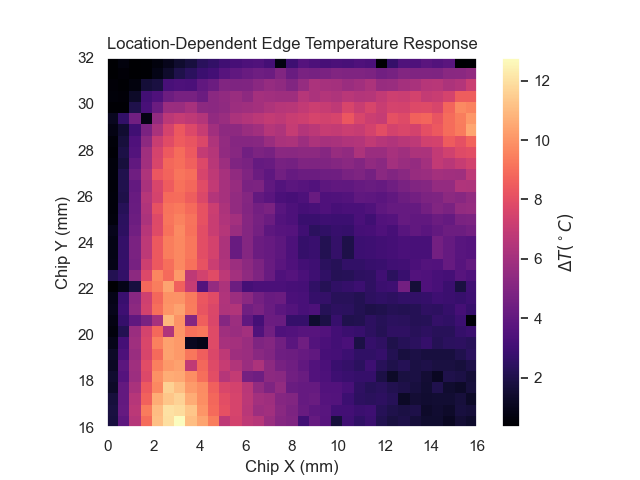

In [11]:
padleft, padright = 120, 120


leftedge_dset = get_highest_window_value(edge_delta, boo, (padleft, padright))
topedge_dset = get_highest_window_value(np.array(top_edge_delta), boo, (padleft, padright))
chip_dset = get_highest_window_value(ROI_delta, boo, (padleft, padright))
raw_chip_dset = get_highest_window_value(ROI_rawdelta, boo, (padleft, padright))
aggchip_dset = get_highest_window_value(ROI_aggdelta, boo, (padleft, padright))

plt.close(99)
fig99, ax99 = plt.subplots(num=99)
# fig99.tight_layout()
ax99.set_title("Location-Dependent Edge Temperature Response")
# print(pad_indices(boo, (1, 1)))
# dset = ROI_delta
# hm = ax99[0].imshow(ROI_delta[boo], interpolation="None", origin="lower", extent=[0, 16, 16, 32])
hm2 = ax99.imshow(np.maximum(topedge_dset, leftedge_dset), interpolation="None", origin="lower", extent=[0, 16, 16, 32], cmap="magma")
# cb = fig99.colorbar(hm)

ax99.grid(False)

cb = fig99.colorbar(hm2)
cb.ax.set_ylabel("$\Delta T (^\circ C)$")
ax99.set_xlabel("Chip X (mm)")
ax99.set_ylabel("Chip Y (mm)")
plt.show()

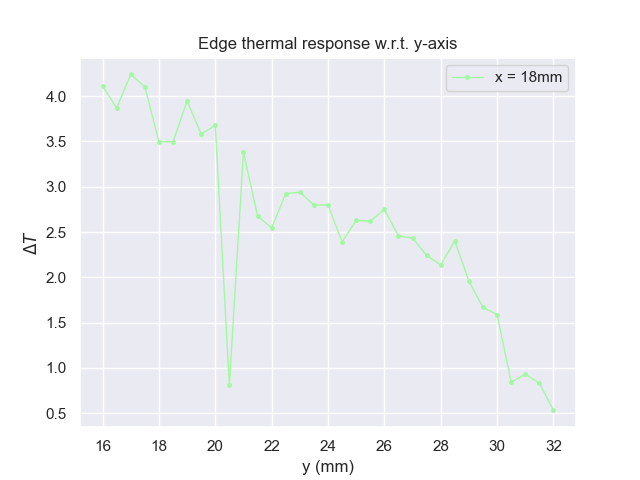

In [12]:
color = iter(cm.rainbow(np.linspace(0, 1, 33)))

plt.close("853")
fig853, ax853 = plt.subplots(num="853")

x = np.linspace(16, 32, 33)

for num, (col, c) in enumerate(zip(leftedge_dset.T, color)):
    if num == 8:
        y2 = col
    if num == 6:
        y = col
    if num == 18:
        ax853.plot(np.linspace(16, 32, 33), col, color=c, markersize=5, lw=1, marker=".", label=f"x = {num}mm")

ax853.set_title("Edge thermal response w.r.t. y-axis")
ax853.set_ylabel("$\Delta T$")
ax853.set_xlabel("y (mm)")
ax853.legend(ncol=2, labelspacing=0.05)

In [13]:
def occlusion(x, w, c):
    '''
    Using a domain-shifted razor blade model, return the proportion of laser power
    that will hit the edge of the chip given a laser with a certain waist and distance from the edge.

    parameters:

    x float, array[float]: The distance from the edge of the chip in millimeters

    w float: The gaussian beam waist w(z) in millimeters of the laser at the point of intersection with the chip.
             Related to FWHM by FWHM = w * sqrt(2 * np.log(2))

    c float: x-offset. Used to tune the position of the exact edge.

    returns:

    beamprop float: a number between 0 and 1 representing the effective laser power after occlusion.

    '''
    return 1 - 0.5 * (1 - erf(((x - c) * (np.sqrt(2)) / w)))

def expmodel(x, a, b, c):
    '''
    Exponential falloff fit function
    '''
    return a * np.exp((x - c) * b)

def beam_falloff(x, a, b, c, w):
    '''
    Function to characterize lasing temperature response falloff w.r.t. distance from an edge
    '''
    return expmodel(x, a, b, c) * occlusion(x, w, c)

def spar(x, boost, w, c, spar_width):
    '''
    Boosts temperature based off of amount of beam hitting spar
    '''
    return 1 + boost * (occlusion(x-c, w, -spar_width / 2) - occlusion(x-c, w, spar_width / 2))

def beam_falloff_spar_independent(x, a, w, edge_offset, boost, spar_width):
    return a * spar(x, boost, w, 16, spar_width) * occlusion(x, -w, edge_offset)

def beam_falloff_spar_independent_no_occ(x, a, w, edge_offset, boost, spar_width):
    return a * spar(x, boost, w, 16, spar_width)

def beam_falloff_spar(y, w, edge_offset, boost, spar_width):
    return spar(y, boost, w, 16, spar_width) * occlusion(x, -w, edge_offset)

def edge_model(x, y, a, b, c, w, edge_offset, boost, spar_width):
    pass

def sub_exp(x, a, b, c):
    return a * (1 - np.exp((x - c) * b))

def subexp2(x, a, b1, b2, c1, c2):
    return a * (1 - np.exp((x - c1) * b1) - np.exp((x - c2) * b2))

def linfitmodel(p, m, b):
    return m * p + b

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


11
fit for x = 11.0mm failed.
fit for x = 15.5mm failed.


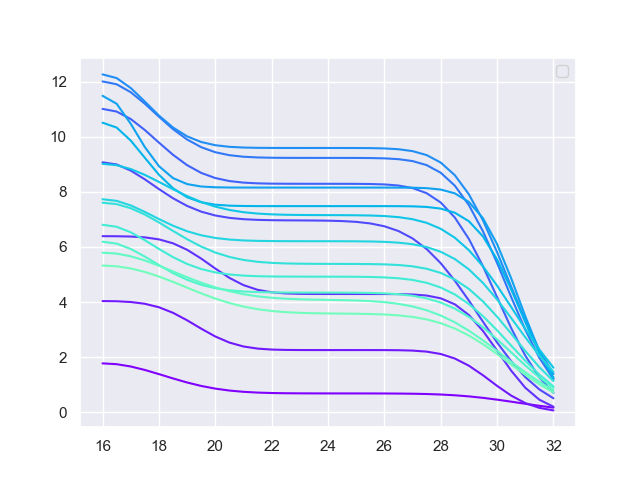

In [14]:
plt.close(52)
fig52, ax52 = plt.subplots(num=52)


param_names = ["base amp.", "waist", "edge distance", "boost amp", "spar width"]
param_data = []
sigma_names = list(name + " sigma" for name in param_names)
sigma_data = []
colxdata = []

col_labels = ["x (mm)"] + param_names + sigma_names
print(len(col_labels))
# params, pcov = curve_fit(linfitmodel, xf, yf)
# yflat = y - linfitmodel(x, *params) + (np.min(y) - np.min(y - linfitmodel(x, *params)))

x = np.linspace(16, 32, 33)
color = iter(cm.rainbow(np.linspace(0, 1, 33)))
for num, (col, c) in enumerate(zip(leftedge_dset.T, color)):
    colx = num / 2
    try:
        mparams, mpcov = curve_fit(beam_falloff_spar_independent, x, col, p0=(8.38, 1.8, 30.3, 0.25, 2.5))
        sigma = np.sqrt(np.diag(mpcov))
        param_data.append(mparams)
        sigma_data.append(sigma)
        colxdata.append(colx)
        if colx < 8:
            ax52.plot(x, beam_falloff_spar_independent(x, *mparams), color=c)
    except RuntimeError:
        print(f"fit for x = {colx}mm failed.")

colxdata = np.array([colxdata]).T

pdata = np.hstack((colxdata, param_data, sigma_data))
pdata = pd.DataFrame(pdata, columns=col_labels)

# params1, pcov1 = curve_fit(beam_falloff_spar, x, y, p0=(8.38, 1.8, 30.3, 0.25, 2.5))
# print(params1)
# print(np.sqrt(np.diag(pcov1)))

# ax52.plot(x, y, marker=".", markersize=10, lw=0, color="tab:blue")
# ax52.plot(x, yflat, marker=".", markersize=10, lw=0, color="tab:green")
ax52.legend()

plt.show()

waist: 3.257 +/- 0.108
edge distance: 30.358 +/- 0.037
boost amp: 0.634 +/- 0.031
spar width: 8.264 +/- 0.315
[13.8259205  -0.2290948   1.56257101  1.77647911] [0.13722812 0.00286844 0.03000684 0.04085415]


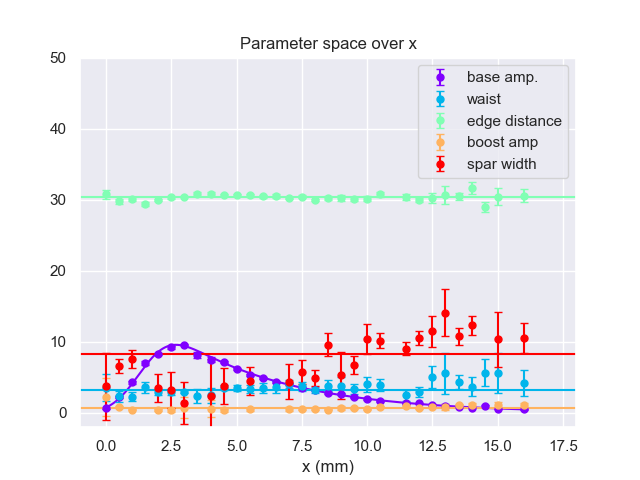

In [15]:
plt.close(35)
fig35, ax35 = plt.subplots(num=35)

color = iter(cm.rainbow(np.linspace(0, 1, len(param_names))))
for param, sigma, c in zip(param_names, sigma_names, color):
    x = pdata["x (mm)"]
    y = pdata[param]
    y_sigma = pdata[sigma]
    sigma_filter = y_sigma <= 10
    x = x[sigma_filter]
    y = y[sigma_filter]
    y_sigma = y_sigma[sigma_filter]
    if True:
        if param == "base amp.":
            xmodel_params, pcov = curve_fit(beam_falloff, x, y, p0=(15,-0.3,1,3.6), absolute_sigma=True, sigma=y_sigma)
            xmodel_param_sigma = np.sqrt(np.diag(pcov))
            x_fine = np.linspace(0, 16, 200)
            ax35.plot(x_fine, beam_falloff(x_fine, *xmodel_params), color=c)
        else:
            weights = 1 / y_sigma**2
            param_av = np.average(y, weights=weights)
            param_sigma = np.sqrt(1 / np.sum(weights))
            ax35.axhline(param_av, 0, 1, color=c)
            print(f"{param}: {param_av:.3f} +/- {param_sigma:.3f}")
        ax35.errorbar(x, y, yerr=y_sigma, label=param, marker=".", capsize=3, linestyle="None", markersize=10, color=c)

print(xmodel_params, xmodel_param_sigma)

ax35.set_ylim(-2, 50)
ax35.set_xlim(-1,18)
ax35.set_title("Parameter space over x")
ax35.set_xlabel("x (mm)")
ax35.legend(loc="upper right")
plt.show()

[1, -0.22909479745191558, 1.5625710105089072, 1.776479108589198]
(1, -0.22909479745191558, 1.5625710105089072, 1.776479108589198)
(1, 3.307, 30.33, 0.567, 8.166)
(1, -0.22909479745191558, 1.5625710105089072, 1.776479108589198)
(1, 3.307, 30.33, 0.567, 8.166)


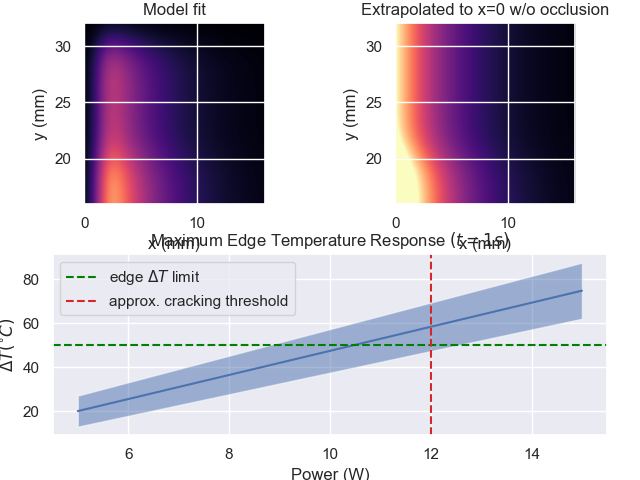

In [16]:
dg = np.linspace(0, 16, 330)
xg, yg = np.meshgrid(dg, dg)

yg += 16

edge_power_model_params = np.array((2.8854819090868404, -3.8139191721405954))
epmp_sigma = np.array((0.29888804, 2.21966406))
ymodel_params = (1, 3.307, 30.330, 0.567, 8.166)

falloff_params_x = ()
normalized_xparams = list(xmodel_params)
normalized_xparams[0] = 1
print(normalized_xparams)
normalized_xparams= tuple(normalized_xparams)

def left_edge_heating(x, y, power, params_p=edge_power_model_params, params_x=normalized_xparams[:], params_y=ymodel_params, occlude=False):
    print(params_x)
    print(params_y)
    if occlude:
        return beam_falloff(x, *params_x) * beam_falloff_spar_independent(y, *params_y) * linfitmodel(power, *params_p)
    else:
            return expmodel(x, *params_x[:-1]) * beam_falloff_spar_independent_no_occ(y, *params_y) * linfitmodel(power, *params_p)

powers = np.linspace(5, 15, 6)
y16 = beam_falloff_spar_independent_no_occ(16, *ymodel_params) * expmodel(0, *normalized_xparams[:-1])
responses = linfitmodel(powers, *edge_power_model_params)  * 0.85 * y16
y1 = linfitmodel(powers, *(edge_power_model_params - epmp_sigma)) * 0.85 *y16
y2 = linfitmodel(powers, *(edge_power_model_params + epmp_sigma)) * 0.85 *y16

plt.close(14)
fig14 = plt.figure(num=14)
gs = fig14.add_gridspec(2, 2)
ax141 = fig14.add_subplot(gs[0, 0])
ax142 = fig14.add_subplot(gs[0, 1])
ax143 = fig14.add_subplot(gs[1, :])
fig14.tight_layout()
power=10
ax142.imshow(left_edge_heating(xg, yg, power) * 0.85, origin="lower", cmap="magma", vmin=0, vmax=30, extent=[0, 16, 16, 32])
ax141.imshow(left_edge_heating(xg, yg, power, occlude=True) * 0.85, origin="lower", cmap="magma", vmin=0, vmax=30, extent=[0, 16, 16, 32])
# ax143.plot(dg + 16, left_edge_heating(xg, yg, power)[:,0] * 0.85)

ax142.set_xlabel("x (mm)")
ax141.set_xlabel("x (mm)")

ax142.set_ylabel("y (mm)")
ax141.set_ylabel("y (mm)")

ax143.plot(powers, responses)
ax143.fill_between(powers, y1, y2, alpha=0.5)

ax143.set_title(fr"Maximum Edge Temperature Response $(t=1s)$")
ax142.set_title(fr"Extrapolated to x=0 w/o occlusion")
ax141.set_title(fr"Model fit")
ax143.set_xlabel("Power (W)")
ax143.set_ylabel("$\Delta T (^{\circ}C)$")
ax143.axhline(50, 0, 1, linestyle="--", color="green", label="edge $\Delta T$ limit")
ax143.axvline(12, 0, 1, linestyle="--", color="tab:red", label=r"approx. cracking threshold")
ax143.legend()

(1, -0.22909479745191558, 1.5625710105089072, 1.776479108589198)
(1, 3.307, 30.33, 0.567, 8.166)


Text(0, 0.5, '$P_{max} (W)$')

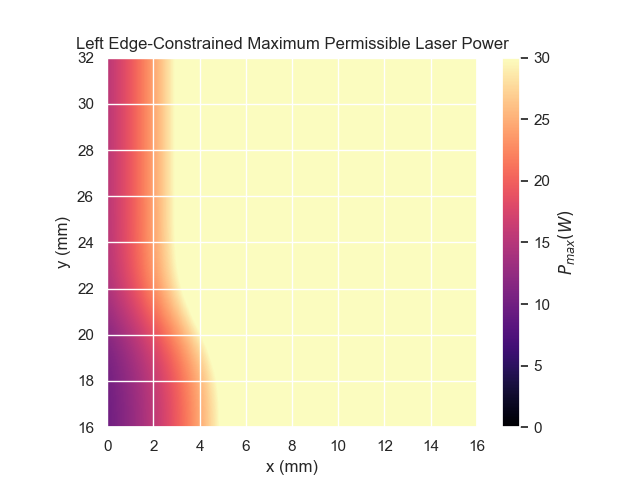

In [17]:
plt.close(92)
fig92, ax92 = plt.subplots(num=92)

ax92.set_title("Left Edge-Constrained Maximum Permissible Laser Power")
temps = left_edge_heating(xg, yg, power) * 0.85

def inverse_linfit(y, m, b):
    return (y - b) / m

def get_max_power(x, y, threshold, params_p=edge_power_model_params, params_x=normalized_xparams[:], params_y=ymodel_params, occlude=False):
    if occlude:
        boost = 1 / (beam_falloff(x, *params_x) * beam_falloff_spar_independent(y, *params_y) * 0.85)
    else:
        boost = 1 / (expmodel(x, *params_x[:-1]) * beam_falloff_spar_independent_no_occ(y, *params_y) * 0.85)

    return inverse_linfit(threshold, *params_p) * boost

b = ax92.imshow(get_max_power(xg, yg, 50), origin="lower", cmap="magma", vmin=0, vmax=30, extent=[0, 16, 16, 32])
ax92.set_xlabel("x (mm)")
ax92.set_ylabel("y (mm)")
cb = fig92.colorbar(b)
cb.ax.set_ylabel("$P_{max} (W)$")


(1, -0.22909479745191558, 1.5625710105089072, 1.776479108589198)
(1, 3.307, 30.33, 0.567, 8.166)
1.2386324917667821


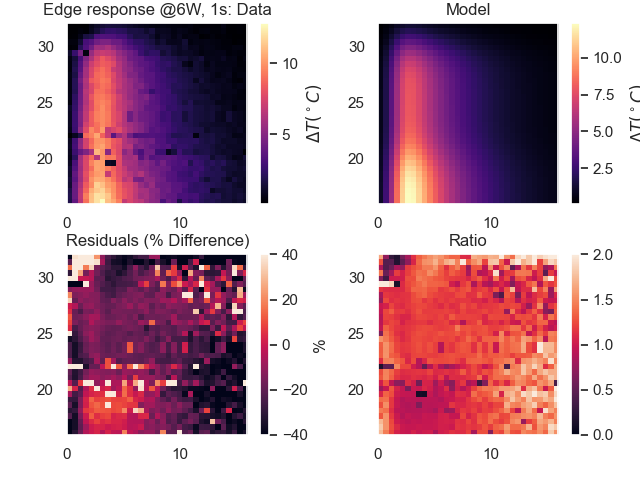

In [18]:
dg = np.linspace(0, 16, 33)
xg, yg = np.meshgrid(dg, dg)

yg += 16
power = 6
chipmodel_edge = left_edge_heating(xg, yg, power, occlude=True) * 0.85

plt.close(12)
fig12, ax12 = plt.subplots(2, 2, num=12)
fig12.tight_layout()

v = ax12[0][1].imshow(chipmodel_edge, extent=[0, 16, 16, 32], origin="lower", cmap="magma")
dv1 = ax12[0][0].imshow(leftedge_dset, interpolation="None", origin="lower", extent=[0, 16, 16, 32], cmap="magma")
dv2 = ax12[1][0].imshow((chipmodel_edge - leftedge_dset) / leftedge_dset * 100, interpolation="None", origin="lower", extent=[0, 16, 16, 32], vmin=-40, vmax=40)
dv3 = ax12[1][1].imshow(leftedge_dset / chipmodel_edge, interpolation="None", origin="lower", extent=[0, 16, 16, 32], vmin=0, vmax=2)

print(np.mean(leftedge_dset / chipmodel_edge))

for a in ax12.flatten():
    a.grid(False)

cb1 = fig12.colorbar(v); cb2 = fig12.colorbar(dv1); cb3 = fig12.colorbar(dv2); cb4 = fig12.colorbar(dv3)


ax12[0][1].set_title("Model")
ax12[0][0].set_title("Edge response @6W, 1s: Data")

ax12[1][0].set_title("Residuals (% Difference)")
ax12[1][1].set_title("Ratio")

cb1.ax.set_ylabel("$\Delta T (^\circ C)$")
cb2.ax.set_ylabel("$\Delta T (^\circ C)$")
cb3.ax.set_ylabel("%")
plt.show()

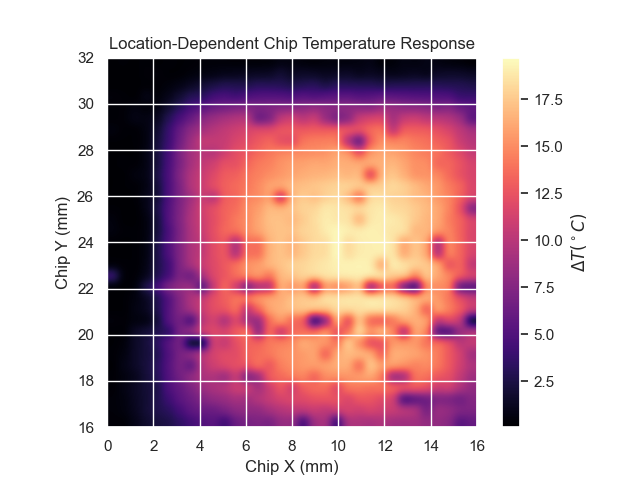

In [19]:
padleft, padright = 200, 200


plt.close(92)
fig92, ax92 = plt.subplots(num=92)
# fig99.tight_layout()
ax92.set_title("Location-Dependent Chip Temperature Response")

hm2 = ax92.imshow(chip_dset, interpolation="gaussian", origin="lower", extent=[0, 16, 16, 32], cmap="magma")
# cb = fig99.colorbar(hm)
cb = fig92.colorbar(hm2)
cb.ax.set_ylabel("$\Delta T (^\circ C)$")
ax92.set_xlabel("Chip X (mm)")
ax92.set_ylabel("Chip Y (mm)")
plt.show()

## HALF ROI Model

In [20]:
def spar_dampen(x, boost, w, c, spar_width):
    return spar(x, boost, -w, c, spar_width)

# def ROI_xmodel(x, w, a, b, c1=0, c3=0, boost=0.7578560682778519, c2=17.094255950785502, spar_width=1.09, b2=0, c4=-9000):
#     return sub_exp(x, a, b, c3) * occlusion(x, w, c1) * spar_dampen(x, boost, w, c2, spar_width) * sub_exp(x, 1, -b2, -c4)

def ROI_xmodel(x, w, a, b, c1=0, c2=0):
    return sub_exp(x, a, b, c2) * occlusion(x, w, c1)

def ROI_ymodel(x, w, a, b, c3=0, c4=0):
    return sub_exp(-(x - 16), a, b, c4) * occlusion(-(x - 16), w, c3)

# def ROI_xmodel(x, w, a, b1, b2, c1, c2, c3, boost, spar_width):
#     return subexp2(x, a, b1, b2, c1, c2)

def m2(x, w, a, b, c1=0, c3=0, boost=0.7578560682778519, c2=17.094255950785502, spar_width=1.09):
    return sub_exp(x, a, b, c3)


# plt.close(31)
# fig31, ax31  = plt.subplots(num=31)
# ax31.plot(x_fine, ROI_ymodel(x_fine, *p0), color=c)

[[0.28825409 0.24443565 0.92205614 ... 7.70449233 5.09750482 5.99720027]
 [0.35340146 0.54759163 1.18347997 ... 8.32735953 7.46758356 7.2451674 ]
 [0.37721152 0.55599811 1.28754343 ... 6.84381608 6.22785186 7.57680933]
 ...
 [0.10165864 0.12488589 0.11734852 ... 2.85900119 2.90749073 2.61746002]
 [0.20181647 0.13151351 0.14380452 ... 1.5815028  1.55985283 1.3463143 ]
 [0.16810927 0.2395795  0.15754157 ... 0.44833954 0.3545951  0.12560378]]
fit 16.0 mm failed.
fit 20.0 mm failed.
fit 20.5 mm failed.
fit 29.5 mm failed.
fit 30.5 mm failed.


Text(0.5, 0, 'x (mm)')

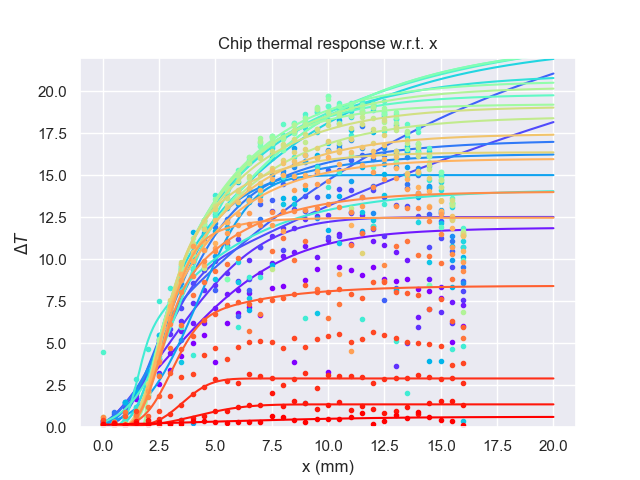

In [21]:
color = iter(cm.rainbow(np.linspace(0, 1, 33)))

plt.close("853")
fig853, ax853 = plt.subplots(num="853")

series = []

p0=(1.52, 22.98932155257467, -0.20511254082333636, 2.13145952676378365, 1.0887325475324638)

x = np.linspace(0, 16, 33)
xg = np.linspace(0, 20, 330)
y = []


param_names = ["waist", "base amp", "exp1 b", "edge distance", "exp1 edge distance"]
param_data = []
sigma_names = list(name + " sigma" for name in param_names)
sigma_data = []
colydata = []



col_labels = ["y (mm)"] + param_names + sigma_names
print(chip_dset)
ax853.set_ylim(0, 22)
# ROW
for num, (col, c) in enumerate(zip(chip_dset, color)):
    # c="tab:red"
    series.append(col)
    coly = num / 2 + 16
    y.append(coly)
    filt = x <= 12
    
    n = (32 - 16) * 2
    n = 50
    try:
        params, pcov = curve_fit(ROI_xmodel, x[filt], col[filt], p0=p0)
        sigma = np.sqrt(np.diag(pcov))
        param_data.append(params)
        sigma_data.append(sigma)
        colydata.append(coly)
        if num == n or n == 50:
            pass
            # print(params)
            ax853.plot(xg, ROI_xmodel(xg, *params), color=c)
    except RuntimeError:
        print(f"fit {coly} mm failed.")
    if num == n or n == 50:
        pass
        ax853.plot(x, col, color=c, markersize=6, lw=0, marker=".", label=f"y = {num}mm")

'''
sub_exp(x, a, b, c1) * occlusion(x, w, c1) * 
'''


colydata = np.array([colydata]).T

pdata = np.hstack((colydata, param_data, sigma_data))
pdata = pd.DataFrame(pdata, columns=col_labels)
pdata.replace([np.inf, -np.inf], np.nan, inplace=True)
pdata.dropna(inplace=True)

# print(pdata)

ax853.set_title("Chip thermal response w.r.t. x")
ax853.set_ylabel("$\Delta T$")
ax853.set_xlabel("x (mm)")
# ax853.legend(ncol=2, labelspacing=0.05, loc="upper right")

waist: 1.770 +/- 0.081
exp1 b: -0.274 +/- 0.010
edge distance: 2.287 +/- 0.063
exp1 edge distance: 1.007 +/- 0.081
[1.770270441753811, 1, -0.2735352372899326, 2.2865247754982008, 1.0065000939076885]
[2.2833947283225537, 1, -0.3027690531537902, -14.427449043552523, -16.87746091076302]
[  2.28339473  21.95037514  -0.30276905 -14.42744904 -16.87746091]


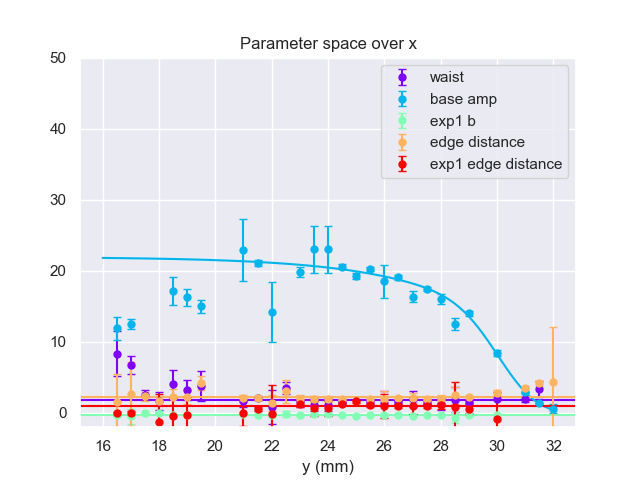

In [22]:
plt.close(34)
fig34, ax34 = plt.subplots(num=34)
p0=(1.52, 22.98932155257467, -0.20511254082333636, 2.13145952676378365 - 16, 1.0887325475324638 - 16)
color = iter(cm.rainbow(np.linspace(0, 1, len(param_names))))

ROIx_params = []

for param, sigma, c in zip(param_names, sigma_names, color):
    x = pdata["y (mm)"]
    y = pdata[param]
    y_sigma = pdata[sigma]
    sigma_filter = y_sigma <= 10
    x = x[sigma_filter]
    y = y[sigma_filter]
    y_sigma = y_sigma[sigma_filter]

    fitfilter = x >= 20
    
    if True:
        if param == "base amp":
            ymodel_params, pcov = curve_fit(ROI_ymodel, x[fitfilter], y[fitfilter], p0=p0, absolute_sigma=True, sigma=y_sigma[fitfilter])
            x_fine = np.linspace(16, 32, 200)
            ax34.plot(x_fine, ROI_ymodel(x_fine, *ymodel_params), color=c)
        else:
            weights = 1 / y_sigma**2
            param_av = np.average(y, weights=weights)
            ROIx_params.append(param_av)
            param_sigma = np.sqrt(1 / np.sum(weights))
            ax34.axhline(param_av, 0, 1, color=c)
            print(f"{param}: {param_av:.3f} +/- {param_sigma:.3f}")
        ax34.errorbar(x, y, yerr=y_sigma, label=param, marker=".", capsize=3, linestyle="None", markersize=10, color=c)

ROIx_params.insert(1, 1)
ROIy_params = list(np.copy(ymodel_params))
ROIy_params[1] = 1
print(ROIx_params)
print(ROIy_params)
print(ymodel_params)

ax34.set_ylim(-2, 50)
# ax34.set_xlim(-1,18)
ax34.set_title("Parameter space over x")
ax34.set_xlabel("y (mm)")
ax34.legend(loc="upper right")
plt.show()

0.9628710592991072
8.70986280235483
0.9380125975227176


C:\Users\allen\AppData\Local\Temp\ipykernel_26952\3013321886.py:13: RuntimeWarning: invalid value encountered in sqrt
  return ((-b + np.sqrt(b**2 - 4 * a * (c - y))) / (2 * a))


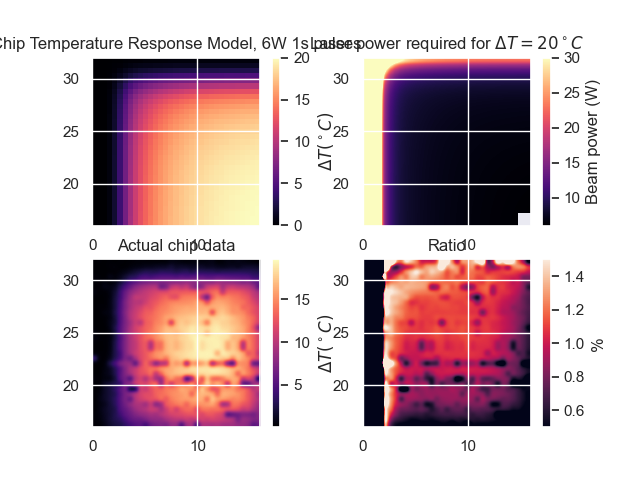

In [23]:
plt.close("lk")
figlk, axlk = plt.subplots(2, 2, num="lk")
quad_params = (3.50573364235093, -42.00264291934413, 146.27680319875776)
exp_params = (1.154339740125389, 0.38220019605273087, -1.0463817190209532)# (1.4242965440488204, 0.3687910673725343, -1.6889407870593522)
dg = np.linspace(0, 16, 33)
xg, yg = np.meshgrid(dg, dg)
yg += 16

def power_model(p, a, b, c):
    return a * p**2 + b * p + c

def solve_power(y, a, b, c):
    return ((-b + np.sqrt(b**2 - 4 * a * (c - y))) / (2 * a))

def solve_exp(y, a, b, c):
    return (1 / b) * np.log(y / a) + c


# print(solve_power(33, *quad_params))

print(ROI_ymodel(22, *ROIy_params))

halfmodel = ROI_xmodel(xg, *ROIx_params) * ROI_ymodel(yg, *ymodel_params)

def pos_model(x, y, xpar=ROIx_params, ypar=ROIy_params):
    return ROI_xmodel(x, *xpar) * ROI_ymodel(y, *ypar)

def half_model(x, y, p, xpar=ROIx_params, ypar=ROIy_params, ppar=quad_params):
    return pos_model(x, y, xpar=xpar, ypar=ypar) * power_model(p, *ppar)

def get_power(x, y, deltaT):
    boost = deltaT / np.abs(pos_model(x, y))
    # print(solve_power(boost, *quad_params))
    return solve_power(boost, *quad_params)

halfmodel = half_model(xg, yg, 6)

print(get_power(8, 28, 30))

ratio = chip_dset / halfmodel
print(np.mean(ratio[np.abs(ratio) < 2]))

v = axlk[0][0].imshow(halfmodel, origin="lower", extent=[0, 16, 16, 32], cmap="magma")
# axlk[0][1].imshow(chip_dset, interpolation="gaussian", origin="lower", extent=[0, 16, 16, 32], cmap="magma")
dv1 = axlk[1][0].imshow(chip_dset, interpolation="gaussian", origin="lower", extent=[0, 16, 16, 32], cmap="magma")
dv2 = axlk[1][1].imshow(ratio, interpolation="gaussian", origin="lower", extent=[0, 16, 16, 32], vmin=0.5, vmax=1.5)

dv3 = axlk[0][1].imshow(get_power(xg, yg, 20), interpolation="gaussian", origin="lower", extent=[0, 16, 16, 32], cmap="magma", vmax=30)

cb1 = figlk.colorbar(v); cb2 = figlk.colorbar(dv1); cb3 = figlk.colorbar(dv2); cb4 = figlk.colorbar(dv3)


axlk[0][0].set_title("Chip Temperature Response Model, 6W 1s pulses")
axlk[0][1].set_title("Laser power required for $\Delta T = 20 ^\circ C$")

axlk[1][0].set_title("Actual chip data")
axlk[1][1].set_title("Ratio")

cb1.ax.set_ylabel("$\Delta T (^\circ C)$")
cb2.ax.set_ylabel("$\Delta T (^\circ C)$")
cb4.ax.set_ylabel("Beam power (W)")
cb3.ax.set_ylabel("%")

gaussian_kernel = (1 / 16) * np.array([[1, 2, 1],[2, 4, 2],[1, 2, 1]])
log_kernel = np.array([[0, 1, 0],[1, -4, 1],[0, 1, 0]])

# axlk[1][1].imshow(convolve2d(ratio, log_kernel), interpolation="None", origin="lower", extent=[0, 16, 16, 32], vmin=-0.05, vmax=0.05)


TypeError: ROI_xmodel() takes from 4 to 6 positional arguments but 11 were given

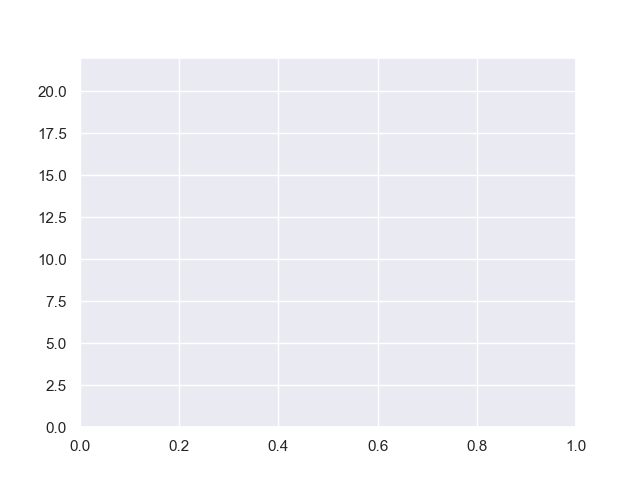

In [24]:
color = iter(cm.rainbow(np.linspace(0, 1, 33)))

plt.close("853")
fig853, ax853 = plt.subplots(num="853")

series = []

p0=(1.52, 22.98932155257467, -0.20511254082333636, 2.13145952676378365, 0.89, 0.7578560682778519, 17.094255950785502, 1.0887325475324638,
    -0.805, -35)

x = np.linspace(0, 16, 33)
xg = np.linspace(0, 20, 330)
y = []


param_names = ["waist", "base amp", "exp1 b", "edge distance", "exp1 edge distance", "boost", "c2", "width", "exp2 b", "spar distance"]
param_data = []
sigma_names = list(name + " sigma" for name in param_names)
sigma_data = []
colydata = []



col_labels = ["y (mm)"] + param_names + sigma_names

ax853.set_ylim(0, 22)

for num, (col, c) in enumerate(zip(chip_dset, color)):
    # c="tab:red"
    series.append(col)
    coly = num / 2 + 16
    y.append(coly)
    filt = x <= 10
    n = (32 - 16) * 2
    n = 50
    try:
        params, pcov = curve_fit(ROI_xmodel, x[filt], col[filt], p0=p0)
        sigma = np.sqrt(np.diag(pcov))
        param_data.append(params)
        sigma_data.append(sigma)
        colydata.append(coly)
        if num == n or n == 50:
            # print(params)
            ax853.plot(xg, ROI_xmodel(xg, *params) * sub_exp(-xg, 1, -0.4, -18), color=c)
            ax853.plot(xg, sub_exp(-xg, 1, -0.4, -18), color=c)
            # ax853.plot(xg, occlusion(xg, 1.6, 15) * 30)
    except RuntimeError:
        print(f"fit {coly} mm failed.")
    if num == n or n == 50:
        ax853.plot(x, col, color=c, markersize=6, lw=0, marker=".", label=f"y = {num}mm")

'''
sub_exp(x, a, b, c1) * occlusion(x, w, c1) * 
'''


colydata = np.array([colydata]).T

pdata = np.hstack((colydata, param_data, sigma_data))
pdata = pd.DataFrame(pdata, columns=col_labels)
print(pdata)

ax853.set_title("Chip thermal response w.r.t. x")
ax853.set_ylabel("$\Delta T$")
ax853.set_xlabel("x (mm)")
# ax853.legend(ncol=2, labelspacing=0.05, loc="upper right")

In [ ]:
plt.close(35)
fig35, ax35 = plt.subplots(num=35)

color = iter(cm.rainbow(np.linspace(0, 1, len(param_names))))
print(param_names)
for param, sigma, c in zip(param_names, sigma_names, color):
    x = pdata["y (mm)"]
    y = pdata[param]
    y_sigma = pdata[sigma]
    sigma_filter = y_sigma <= 10
    x = x[sigma_filter]
    y = y[sigma_filter]
    y_sigma = y_sigma[sigma_filter]
    if True:
        if False and param == "base amp":
            print("YEEEEEEEEeee")
            ymodel_params, pcov = curve_fit(ROI_xmodel, x, y, p0=p0, absolute_sigma=True, sigma=y_sigma)
            x_fine = np.linspace(0, 16, 200)
            ax35.plot(x_fine, ROI_xmodel(x_fine, *ymodel_params), color=c)
        else:
            weights = 1 / y_sigma**2
            param_av = np.average(y, weights=weights)
            param_sigma = np.sqrt(1 / np.sum(weights))
            ax35.axhline(param_av, 0, 1, color=c)
            print(f"{param}: {param_av:.3f} +/- {param_sigma:.3f}")
        ax35.errorbar(x, y, yerr=y_sigma, label=param, marker=".", capsize=3, linestyle="None", markersize=10, color=c)

# ax35.set_ylim(-2, 50)
# ax35.set_xlim(-1,18)
ax35.set_title("Parameter space over x")
ax35.set_xlabel("y (mm)")
ax35.legend(loc="upper right")
plt.show()

In [ ]:
x, y = np.meshgrid(np.linspace(0, 16, 200),np.linspace(0, 16, 200))
y += 16

plt.close(5)
fig5, ax5 = plt.subplots(num=5)
ax5.imshow(ROI_xmodel(x, *par) * ROI_xmodel((y - 16), *par), origin="upper", cmap="magma")

In [ ]:
plt.close(93)
fig93, ax93 = plt.subplots(num=93)
# fig99.tight_layout()
ax93.set_title("Location-Dependent Chip Temperature Response (AGG)")

dset = ROI_delta

hm2 = ax93.imshow(aggchip_dset, interpolation="None", origin="lower", extent=[0, 16, 16, 32], cmap="magma")
# cb = fig99.colorbar(hm)
cb = fig93.colorbar(hm2)
cb.ax.set_ylabel("$\Delta T (^\circ C)$")
ax93.set_xlabel("Chip X (mm)")
ax93.set_ylabel("Chip Y (mm)")
plt.show()

In [ ]:
color = iter(cm.rainbow(np.linspace(0, 1, 33)))

plt.close("854")
fig854, ax854 = plt.subplots(num="854")

for num, (col, c) in enumerate(zip(chip_dset.T, color)):
    if num != 60:
        ax854.plot(np.linspace(16, 32, 33), col, color=c, markersize=5, lw=1, marker=".", label=f"x = {num}mm")

ax854.set_title("Chip thermal response w.r.t. y-axis, aggressive dataset")
ax854.set_ylabel("$\Delta T$")
ax854.set_xlabel("y (mm)")
ax854.legend(ncol=2, labelspacing=0.05, loc="upper right")

In [ ]:
color = iter(cm.rainbow(np.linspace(0, 1, 33)))

plt.close("853")
fig853, ax853 = plt.subplots(num="853")

series = []

p0=(45.98932155257467, -0.40511254082333636, 32, 3.3294034945112485, 0.7578560682778519, 17.094255950785502, 1.0887325475324638)

y = np.linspace(16, 32, 33)
yg = np.linspace(16, 32, 330)
x = []


param_names = ["base amp", "exp1 b", "edge distance", "waist", "boost"]
param_data = []
sigma_names = list(name + " sigma" for name in param_names)
sigma_data = []
colxdata = []

col_labels = ["y (mm)"] + param_names + sigma_names
ax853.plot(yg, ROI_xmodel(-yg, *p0), color=c)
for num, (col, c) in enumerate(zip(chip_dset.T, color)):
    series.append(col)
    colx = num / 2
    x.append(colx)
    ax853.plot(y, col, color=c, markersize=6.73498712, lw=0, marker=".", label=f"x = {num}mm")
    try:
        params, pcov = curve_fit(ROI_xmodel, y, col, p0=p0)
        sigma = np.sqrt(np.diag(pcov))
        param_data.append(params)
        sigma_data.append(sigma)
        colxdata.append(colx)
        ax853.plot(yg, ROI_xmodel(yg, *params), color=c)
    except RuntimeError:
        print(f"fit {colx} mm failed.")
    

colxdata = np.array([colxdata]).T

pdata = np.hstack((colxdata, param_data, sigma_data))
pdata = pd.DataFrame(pdata, columns=col_labels)

ax853.set_title("Chip thermal response w.r.t. x")
ax853.set_ylabel("$\Delta T$")
ax853.set_xlabel("x (mm)")
# ax853.legend(ncol=2, labelspacing=0.05, loc="upper right")